<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

Let's first import the libraries we'll be using. We're using the same libraries we used in previous projects.

In [47]:
import subprocess
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import pytubefix
import torch
import torchvision
from IPython.display import Video
from pytubefix import YouTube
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

We'll also print out library versions as well as the Python version. This makes our analysis reproducible for anyone who wants to review or reuse our work.

In [48]:
print("torch version : ", torch.__version__)
print("pytube version : ", pytubefix.__version__)
print("torchvision version : ", torchvision.__version__)
print("cv2 version : ", cv2.__version__)

!python --version

torch version :  2.2.2+cu121
pytube version :  8.8.1
torchvision version :  0.17.2+cu121
cv2 version :  4.10.0
Python 3.11.0


### Fetching YouTube Video Data

For this project, we'll use a video of an interview with an Indian Olympic boxer [Mary Kom](https://en.wikipedia.org/wiki/Mary_Kom). She's a legendary athlete with many achievements. Among others, she's the only boxer to ever win eight World Championship medals.

We'll load the video of her interview from YouTube. We want to put the video file in directory `"data"` which should be in the `"project4"` directory.

**Task 4.2.1:** Create a variable for the video directory using `pathlib` syntax.

In [49]:
project_dir = Path("project4")
data_dir = "data"
video_dir = project_dir / data_dir

print(video_dir)

project4/data


Next we'll need to specify the URL of the YouTube video and download the video. We decided to save the video under file name `video_name = "mary_kom.mp4"`.

In [50]:
video_name = "mary_kom.mp4"
video_url = "https://www.youtube.com/watch?v=XScnCdyVbIU"
yt = YouTube(video_url)

Because downloading from YouTube doesn't always work, we wrapped the code in a `try/except` block.

**Task 4.2.2:** Fill in the missing code in the `else` part of the `try/except` block below. If grabbing the YouTube stream worked, we want to download the video to directory `video_dir` using file name `video_name`. 

The video is already available in the following location:

In [5]:
from urllib.error import HTTPError

try:
    stream = yt.streams.get_highest_resolution()
except HTTPError:
    # In case YouTube download faild, we download the video from cloud storage
    print('Downloading from cloud storage...')
    if not (video_dir / video_name).exists():
        video_dir.mkdir(parents=True, exist_ok=True)
        !gcloud storage cp --no--clobber \
           gs://wqu-cv-course-datasets/mary_kom.mp4 \
           $video_dir
else:
    print('Downloading from YouTube...')
    stream.download(output_path=video_dir, filename=video_name)

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [51]:
!ls -l project4/data/

total 2520
drwxr-xr-x 1 root root   12288 Sep 28 12:23 extracted_frames
-rw-r--r-- 1 root root 2565640 Sep 27 19:51 output.mp4


**Task 4.2.3:** Create a variable for the video file path using `pathlib` syntax.

In [52]:
# The following variables you've already defined will be helpful
print(video_dir)
print(video_name)

project4/data
mary_kom.mp4


In [53]:
input_video = video_dir / video_name

print(input_video)

project4/data/mary_kom.mp4


Now let's take a peak of the video.

In [54]:
# Display the video
Video(input_video, width=400)

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

The video is quite long and we'll only need a small portion of it. In a previous project, we 
truncated a video with `ffmpeg`, a command line tool for video and audio editing. This time, let's create a Python function that can cut down the video!

**Task 4.2.4:** Fill in the missing code that defines the signature of the `cut_video` function. By looking at the function's doc string, you can see what the input parameters should be.

In [55]:
def cut_video(input_file, output_file, start_time, duration):
    """
    Cuts a portion of the video.

    :parameter input_file: Path to the input video file.
    :parameter output_file: Path to the output video file.
    :parameter start_time: Start time of the cut in seconds or in `HH:MM:SS` format.
    :parameter duration: Duration of the cut in seconds or in `HH:MM:SS` format.
    """
    command = [
        "ffmpeg",
        "-ss",
        str(start_time),
        "-i",
        input_file,
        "-t",
        str(duration),
        "-c",
        "copy",
        output_file,
    ]
    subprocess.run(command)


cut_video?

Signature: cut_video(input_file, output_file, start_time, duration)
Docstring:
Cuts a portion of the video.

:parameter input_file: Path to the input video file.
:parameter output_file: Path to the output video file.
:parameter start_time: Start time of the cut in seconds or in `HH:MM:SS` format.
:parameter duration: Duration of the cut in seconds or in `HH:MM:SS` format.
File:      /tmp/ipykernel_19/1177039216.py
Type:      function

Before we use this function, we should first prepare the output video path where we want to save the shortened video (`output_file` parameter we need to pass to the function).

**Task 4.2.5:** Create a variable for the output video file path using `pathlib` syntax. Let's call the file `"output.mp4"`. It should be in the same directory as our input video file.

In [56]:
output_video_name = "output.mp4"

output_video = video_dir / output_video_name

print(output_video)

project4/data/output.mp4


**Task 4.2.6:** Call the `cut_video` function using the `input_video` and `output_video` variables you defined in the previous tasks.

In [57]:
start_time = "00:00:00"  # Start at 00 seconds
duration = "00:01:00"  # Cut 1 minute

# Call cut_video function
cut_video(input_video, output_video, start_time, duration)

ffmpeg version 4.3.7-0+deb11u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

Well done! We should be able to display this shortened one minute video we created.

In [58]:
# Display the video
Video(output_video, width=400)

In [59]:
# Delete original video
input_video.unlink()

FileNotFoundError: [Errno 2] No such file or directory: 'project4/data/mary_kom.mp4'

### Exploring and Preparing the Data

Let's learn a bit more about our video data. We're curious about things like the frame rate, total frame count, and frame shape. To get this information, we'll use the `opencv-python` library just like in the previous project (`cv2` which we imported at the top of the notebook).

The first step is to create a video capture using `cv2.VideoCapture` and pass in the path to our video.

**Task 4.2.7:** Create a video capture for the one minute video we're working with. The rest of the code computes the frame rate and total frame count.

In [60]:
video_capture = cv2.VideoCapture(output_video)

if not video_capture.isOpened():
    print("Error: Could not open video.")
else:
    frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Frame rate: {frame_rate}")
    print(f"Total number of frames: {frame_count}")

Frame rate: 25.0
Total number of frames: 1501


Now let's display the first frame. We can fetch the first frame of our video capture by calling the `read()` method on it.

**Task 4.2.8:** Use the video capture variable you defined in the previous task and fetch the first frame. The rest of the code will display the frame.

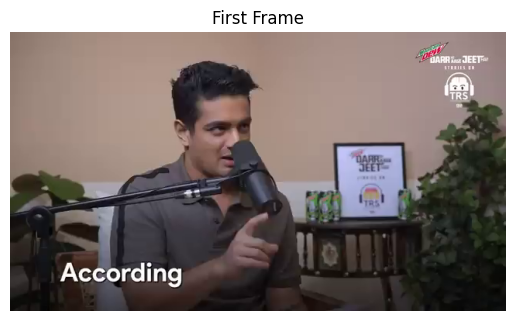

In [61]:
ret, first_frame = video_capture.read()

if ret:
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("First Frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read frame.")

**Task 4.2.9:** Get the shape of the frame and the number of channels by calling the `shape` attribute on the `first_frame` variable.

In [62]:
height, width, channel = first_frame.shape

print("frames height : ", height)
print("frames width : ", width)
print("frames channel : ", channel)

frames height :  360
frames width :  640
frames channel :  3


The next thing we need to do is extract the individual frames from the video. 

**Task 4.2.10:** Create a directory path for the extracted frames using the `pathlib` syntax. This path should be a directory called `extracted_frames` which should be in `video_dir`.

In [63]:
frames_dir = video_dir / "extracted_frames"

frames_dir.mkdir(exist_ok=True)
print(frames_dir)

project4/data/extracted_frames


**Task 4.2.11:** Fill in the missing code below that saves every fifth frame from the video. 

In [64]:
interval = frame_rate * 0.20  # Extract every fifth frame from the video
frame_count = 0

print("Start extracting individual frames...")
while True:
    # read next frame from the video_capture
    ret, frame = video_capture.read()
    if not ret:
        print("Finished!")
        break  # Break the loop if there are no more frames

    # Save frames at every 'interval' frames
    if frame_count % interval == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)

    frame_count += 1

video_capture.release()

Start extracting individual frames...
Finished!


**Task 4.2.12:** Compute the number of frames we've extracted by using `iterdir()` method on the `frames_dir` path. That'll give you a generator that you need to covert to `list` before using`len`. 

In [65]:
n_extraced_frames = len(list(frames_dir.iterdir()))

print(f"We saved {n_extraced_frames} frames.")

We saved 301 frames.


To conclude this lesson, let's display some sample frames that we extracted. The function `display_sample_images` below that'll display a grid of sample frames is the same as the one we used in the previous project.

**Task 4.2.13:** Fill in the missing code in `display_sample_images` function.

In [66]:
def display_sample_images(dir_path, sample=5):
    image_list = []
    images = sorted(dir_path.iterdir())
    if images:
        sample_images = images[:sample]
        for sample_image in sample_images:
            image = read_image(str(sample_image))
            
            # Define resizing transformation that resizes to 240 x 240
            resize_transform = ...
            # Resize image by using `resize_transform`
            image = ...
            image_list.append(image)
    grid = make_grid(image_list, nrow=5)
    image = to_pil_image(grid)
    return image


display_sample_images?

Signature: display_sample_images(dir_path, sample=5)
Docstring: <no docstring>
File:      /tmp/ipykernel_19/2985800784.py
Type:      function

**Task 4.2.14:** Use `display_sample_images` function to display 20 of the frames that we extracted.

In [70]:
# Call function `display_sample_images` on `frames_dir`
display_sample_images(frames_dir, sample=5)

RuntimeError: unable to mmap 4096 bytes from file <project4/data/extracted_frames/.ipynb_checkpoints>: No such device (19)

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).